In [2]:
import keras.metrics
import mne
import os
import os.path as osp
from tqdm import tqdm
from keras.models import load_model

import numpy as np
import pandas as pd
import torch
import winsound



from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras.utils import set_random_seed
from tensorflow import one_hot
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

#from EEGModels import EEGNet, ShallowConvNet, DeepConvNet
from numpy.random import seed
from tensorflow.keras.utils import set_random_seed


import time

In [3]:
mne.set_log_level(verbose="Warning") # set all the mne verbose to warning

seed(2002012)
set_random_seed(2002012)

In [10]:
#init_path = "\\\\bor-nas1.bordeaux.inria.fr\\potiocdata\BCI\\2022 BCI OPEN DATA\\BCI Database - Copie\\Signals"
init_path = "C:\\Users\dtrocell\Documents\ML\Big dataset\signal"
files_dir=os.listdir(init_path)[1:4]
participant_dir= [os.listdir(osp.join(init_path,files_dir[i])) for i in range(len(files_dir))]
print("you have succesfuly acces to the directory : ",init_path)



you have succesfuly acces to the directory :  C:\Users\dtrocell\Documents\ML\Big dataset\signal


In [11]:
participant_dir[0].remove("A40")

In [12]:
def collect_data(files_dir, participant_dir):
    dic_data={}

    for i in range(len(files_dir)):
        for j in range(len(participant_dir[i])):
            #Train dataset
            dic_data[participant_dir[i][j]+"_1"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R1_acquisition.gdf"), verbose="CRITICAL")
            dic_data[participant_dir[i][j]+"_2"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R2_acquisition.gdf"), verbose="CRITICAL")

            #Test dataset
            dic_data[participant_dir[i][j]+"_3"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R3_onlineT.gdf"), verbose="CRITICAL")
            dic_data[participant_dir[i][j]+"_4"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R4_onlineT.gdf"), verbose="CRITICAL")
            try : # allow to manage the one where there is no _5 and _6 files
                dic_data[participant_dir[i][j]+"_5"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R5_onlineT.gdf"), verbose="CRITICAL")
            except FileNotFoundError:
                pass

            try :
                dic_data[participant_dir[i][j]+"_6"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R6_onlineT.gdf"), verbose="CRITICAL")
            except FileNotFoundError:
                pass
    return dic_data

In [13]:
print("START extraction data")
dic_data =  collect_data(files_dir, participant_dir)
print("extraction data DONE")

START extraction data
extraction data DONE


In [15]:
def create_key(df , train = 1 , test = 1 ):

    if "A59" in df :
        keys = np.empty(shape= len(df) * train *2 + (len(df) * test * 4) -2*test ,  dtype=  np.dtype('<U8'))
    else :
        keys = np.empty(shape= len(df) * train *2 + (len(df) * test * 4) ,  dtype=  np.dtype('<U8'))
    i = 0
    for  val  in df :
        if train :
            keys[i : i+2] = [val+"_1" ,val+"_2"]
            i += 2
        if test :
            if val == "A59":
                keys[i : i+2] =  [val+"_3" ,val+"_4"]
                i+= 2
            else :
                keys[i : i+4] =  [val+"_3" ,val+"_4",  val+"_5", val+"_6"]
                i+=4

    return keys


In [16]:
def preprocess(raw, steps = {}):
    """ preprocess the data"""
    assert isinstance(steps, dict), "les steps doivent être un dictionnaire d'étapes"
    raw.load_data()
    if "drop_channels" in steps.keys():
        #remove the wanted channels
        for channel in steps["drop_channels"] : #Pour chaque channel  a supprimer
            if channel in raw.ch_names: raw.drop_channels(channel) # Vérifie qu'il est present et le supprime

    if "filter" in steps.keys():
        assert isinstance(steps["filter"], list), "les paramètres de 'filter' doivent une liste suivant cette forme [l_freq,h_freq]"
        raw.filter(steps["filter"][0], steps["filter"][1], verbose= None)


    return raw



In [17]:
def epoching(dict, key_session =[], steps_preprocess = None , key_events={"769":0 ,"770":1}) :
    """From the dictionary of mne.rawGDF extract all the epochs selected with Key_session
     Return the epochs list as X and tje label as Y"""

    #---------------------------------------------
    tmin= steps_preprocess["tmin"]
    tmax = steps_preprocess["tmax"]
    length_epoch = steps_preprocess["lenght"]
    overlap = steps_preprocess["overlap"]
    #---------------------------------------------

    list_start = np.arange(tmin, (tmax +overlap)- length_epoch, overlap)
    list_stop = np.arange(tmin+length_epoch, (tmax+overlap), overlap)

    #n_chans = len(dict[key_session[0]].ch_names) - len(steps_preprocess["drop_channels"])
    n_chans = 27 # must be changed if we drop more channels
    time_step = int(length_epoch  * dict[key_session[0]].info['sfreq'])
    n_events = len(list_start)* 40 * len(key_session) # 40 represent the number of events in each raw data

    X= np.zeros((n_events, n_chans, time_step))
    Y= np.zeros((n_events))

    i = 0

    #for key in tqdm(key_session , desc="epoching"):
    for key in key_session :

        if steps_preprocess is not None :
            _ =  preprocess(dict[key],steps_preprocess)

        epoch= mne.Epochs(dict[key], mne.events_from_annotations(dict[key],key_events)[0], tmin= -1 , tmax= 5 , baseline=(None, 0))

        assert len(epoch.events[:,2]) == 40, ( "'%s' don't have 40 events it actually have %s " % (key , len(epoch.events[:,2])) )


        for start, stop in zip(list_start, list_stop):

            X[i : i +40 ] = epoch.get_data(tmin=start , tmax=stop)
            Y[i : i +40 ] = epoch.events[:,2]
            i += 40

    Y = one_hot(Y , depth= 2)




    return X,Y

# Transfert Learning RPA

## Data extraction and split

In [86]:
inline_accuracy = [84.375, 55.625, 98.125, 51.25, 51.25, 65.625, 47.5, 56.225, 66.25, 82.5, 51.875, 60, 65, 49.375,
                   75.625, 49.375, 45.625, 82.5, 98.125, 83.125, 56.875, 88.75, 51.875, 93.125, 81.25, 65.625, 45.625,
                   48.125, 52.5, 40.625, 52.5, 55.5, 62.5, 48.125, 90.625, 70, 47.5, 62.5, 81.25, 49.0625, 51.875,
                   51.875, 55, 56.25, 54.375, 54.375, 46.25, 56.625, 55, 52.5, 64.375, 88.75, 46.25, 47.5, 91.875,
                   99.375, 48.75, 66.25, 60, 56.25, 84.375, 90.625, 60, 50, 82.5, 58.75, 51.875, 55, 60.625, 55.625,
                   47.5, 44.375, 86.25, 68.125, 71.875, 80.625, 53.75, 55, 97.5, 49.375, 55, 49.375, 44.375, 76.25,
                   80.625, 62.5, 73.125]

inline_order = ["A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "A10", "A11", "A12", "A13", "A14", "A15", "A16",
                "A17", "A18", "A19", "A20", "A21", "A22", "A23", "A24", "A25", "A26", "A27", "A28", "A29", "A30", "A31",
                "A32", "A33", "A34", "A35", "A36", "A37", "A38", "A39", "A40", "A41", "A42", "A43", "A44", "A45", "A46",
                "A47", "A48", "A49", "A50", "A51", "A52", "A53", "A54", "A55", "A56", "A57", "A58", "A59", "A60", "B61",
                "B62", "B63", "B64", "B65", "B66", "B67", "B68", "B69", "B70", "B71", "B72", "B73", "B74", "B75", "B76",
                "B77", "B78", "B79", "B80", "B81", "C82", "C83", "C84", "C85", "C86", "C87"]

inline_age = [1993, 1993, 1969, 1982, 1985, 1970, 1997, 1992, 1996, 1997, 1997, 1993, 1997, 1994, 1988, 1996, 1997,
              1995, 1985, 1996, 1988, 1989, 1994, 1985, 1999, 1998, 1981, 1995, 1997, 1996, 1978, 1969, 1992, 1993,
              1993, 1990, 1959, 1973, 1996, 1999, 1989, 1994, 1980, 1988, 1977, 1993, 1990, 1997, 1981, 1997, 1975,
              1997, 1991, 1989, 1996, 1998, 1996, 1996, 1991, 1968, 1992, 2002, 2000, 1985, 1998, 1979, 1978, 1999,
              1984, 1998, 1997, 1993, 1969, 1996, 1998, 1998, 1978, 1999, 1994, 1995, 1997, 1995, 1997, 2001, 1991,
              2000, 2000]

data = pd.DataFrame({"accuracy": inline_accuracy, "age": inline_age}, index=[inline_order])
data["age"] = 2021 - data["age"]
data =data.drop(["A40" , "A59"], axis=0)

age_cat = [(19,23), (23, 24), (24, 27), (27,30), (30,40), (40, 62)]
dict_age = {}
for age_min, age_max in age_cat:

     dict_age[(age_min, age_max)] = [x[0] for x in data[np.logical_and(data["age"] > age_min, data["age"] <= age_max)].index]




C:\Users\dtrocell\AppData\Local\Temp\ipykernel_32756\221401765.py:25: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data =data.drop(["A40" , "A59"], axis=0)


In [21]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y
#
# train_gen = DataGenerator(X_train, Y_train, 64)
# valid_train_gen = DataGenerator(X_valid_train, Y_valid_train, 64)
# valid_test_gen = DataGenerator(X_valid_test, Y_valid_test, 64)


## EEG NET

Model extracted from this article : https://iopscience.iop.org/article/10.1088/1741-2552/aace8c/pdf.  Vernon J Lawhern et al.

In [22]:

def EEGNet(nb_classes, Chans = 64, Samples = 128,
           dropoutRate = 0.25, kernLength = 64, F1 = 8,
           D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'SpatialDropout2D'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:

        1. Depthwise Convolutions to learn spatial filters within a
        temporal convolution. The use of the depth_multiplier option maps
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn
        spatial filters within each filter in a filter-bank. This also limits
        the number of free parameters to fit when compared to a fully-connected
        convolution.

        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions.


    While the original paper used Dropout, we found that SpatialDropout2D
    sometimes produced slightly better results for classification of ERP
    signals. However, SpatialDropout2D significantly reduced performance
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.

    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the
    kernel lengths for double the sampling rate, etc). Note that we haven't
    tested the model performance with this rule so this may not work well.

    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.
    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D.
    Inputs:

      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D.
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
    """

    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')

    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                          input_shape = (Chans, Samples, 1),
                          use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False,
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)

    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)

    flatten      = Flatten(name = 'flatten')(block2)

    dense        = Dense(nb_classes, name = 'dense',
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)

    return Model(inputs=input1, outputs=softmax)


In [110]:
n_chans = 27
input_window_samples = 1024
# sfreq = dic_data_train['A1_1'].info["sfreq"]
# ch_names = dic_data_train['A1_1'].info["ch_names"]
n_epochs = 500
cuda = torch.cuda.is_available()
# device = 'cuda' if cuda else 'cpu'
n_classes = 2
batch_size = 32

steps_preprocess = {"filter" : [8,30],
                    "drop_channels" : ['EOG1', 'EOG2', 'EOG3', 'EMGg', 'EMGd'] ,
                    "tmin" : 0.5 , "tmax" : 2.5, "overlap" :1, "lenght": 2,
                    "score" : "TAcc"}

my_callbacks = [
    EarlyStopping(patience=50, monitor="loss"),
    ModelCheckpoint(filepath='./model/best_model.h5', save_best_only=True),
    TensorBoard(log_dir='./logs'),
]

In [92]:
steps_preprocess
isinstance(steps_preprocess["filter"], list)

True

In [113]:

# creer la liste accuracy -> ce seras data
data["accuracy_eegnet"] = [0]*data.shape[0]
# pour chaque groupe

for group in dict_age.values():

    for i_group in tqdm(range(len(group))):


        train_id = group.copy()
        test_id = train_id.pop(i_group)



        key_train_valid  = create_key(train_id , train = 1 , test = 1 )
        key_test  = create_key([test_id] , train = 0 , test = 1 )

        mask =np.array([True,True, True ,True, False, False] *  int(key_train_valid.shape[0]/6))
        np.random.shuffle(mask)
        key_train = key_train_valid[mask]
        key_valid = key_train_valid[~mask]

        X_train, Y_train = epoching(dic_data,key_train, steps_preprocess)
        X_valid, Y_valid = epoching(dic_data,key_valid, steps_preprocess)
        X_test, Y_test = epoching(dic_data,key_test, steps_preprocess)

        train_gen = DataGenerator(X_train, Y_train, 64)
        valid_gen = DataGenerator(X_valid, Y_valid, 64)
        test_gen = DataGenerator(X_test, Y_test, 64)




        model = EEGNet(nb_classes=n_classes, Chans=n_chans, Samples=input_window_samples)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=BinaryAccuracy())

        fit_model =  model.fit(x= train_gen,
                               batch_size = batch_size,
                               epochs = n_epochs ,
                               callbacks= my_callbacks,
                               validation_data= valid_gen,
                               verbose = 0)

        model = load_model("./model/best_model.h5")

        data.loc[group[i_group], "accuracy_eegnet" ]= model.evaluate(x= test_gen)[1]

# apprendre le modele en leave one out





  0%|          | 0/13 [00:00<?, ?it/s]

3/3 [==============================] - 0s 6ms/step - loss: 0.3759 - binary_accuracy: 0.8750


  8%|▊         | 1/13 [06:22<1:16:27, 382.33s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.4675 - binary_accuracy: 0.7625


 15%|█▌        | 2/13 [12:00<1:05:21, 356.51s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.0903 - binary_accuracy: 0.9750


 23%|██▎       | 3/13 [16:12<51:24, 308.48s/it]  

3/3 [==============================] - 0s 5ms/step - loss: 0.6396 - binary_accuracy: 0.6500


 31%|███       | 4/13 [21:28<46:42, 311.42s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.5255 - binary_accuracy: 0.7500


 38%|███▊      | 5/13 [24:55<36:30, 273.83s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.8068 - binary_accuracy: 0.4688


 46%|████▌     | 6/13 [31:39<37:07, 318.25s/it]

3/3 [==============================] - 0s 5ms/step - loss: 0.6028 - binary_accuracy: 0.5813


 54%|█████▍    | 7/13 [36:25<30:45, 307.57s/it]

3/3 [==============================] - 0s 5ms/step - loss: 0.4675 - binary_accuracy: 0.8625


 62%|██████▏   | 8/13 [43:14<28:19, 339.88s/it]

3/3 [==============================] - 0s 5ms/step - loss: 0.2351 - binary_accuracy: 0.9250


 69%|██████▉   | 9/13 [48:42<22:25, 336.37s/it]

3/3 [==============================] - 0s 5ms/step - loss: 0.4306 - binary_accuracy: 0.7750


 77%|███████▋  | 10/13 [55:29<17:54, 358.02s/it]

3/3 [==============================] - 0s 5ms/step - loss: 0.3942 - binary_accuracy: 0.8125


 85%|████████▍ | 11/13 [1:02:16<12:26, 373.02s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.5661 - binary_accuracy: 0.6875


 92%|█████████▏| 12/13 [1:06:08<05:29, 329.97s/it]

3/3 [==============================] - 0s 7ms/step - loss: 0.3421 - binary_accuracy: 0.8500


  0%|          | 0/12 [00:00<?, ?it/s]

3/3 [==============================] - 0s 5ms/step - loss: 0.7040 - binary_accuracy: 0.5437


  8%|▊         | 1/12 [07:11<1:19:09, 431.75s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.3743 - binary_accuracy: 0.8438


 17%|█▋        | 2/12 [14:25<1:12:09, 432.99s/it]

3/3 [==============================] - 0s 5ms/step - loss: 0.7903 - binary_accuracy: 0.5312


 25%|██▌       | 3/12 [21:35<1:04:44, 431.56s/it]

3/3 [==============================] - 0s 5ms/step - loss: 0.5324 - binary_accuracy: 0.7312


 33%|███▎      | 4/12 [28:20<56:07, 420.96s/it]  

3/3 [==============================] - 0s 5ms/step - loss: 1.1823 - binary_accuracy: 0.5250


 42%|████▏     | 5/12 [34:20<46:33, 399.12s/it]

3/3 [==============================] - 0s 5ms/step - loss: 1.2135 - binary_accuracy: 0.5625


 50%|█████     | 6/12 [38:24<34:37, 346.23s/it]

3/3 [==============================] - 0s 5ms/step - loss: 0.7336 - binary_accuracy: 0.6125


 58%|█████▊    | 7/12 [42:19<25:50, 310.07s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.6705 - binary_accuracy: 0.5437


 67%|██████▋   | 8/12 [47:17<20:25, 306.26s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.5119 - binary_accuracy: 0.7750


 75%|███████▌  | 9/12 [53:41<16:31, 330.52s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.7214 - binary_accuracy: 0.5500


 83%|████████▎ | 10/12 [58:50<10:47, 323.80s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.6732 - binary_accuracy: 0.5938


 92%|█████████▏| 11/12 [1:05:24<05:45, 345.36s/it]

3/3 [==============================] - 0s 7ms/step - loss: 0.5774 - binary_accuracy: 0.6875


  0%|          | 0/17 [00:00<?, ?it/s]

3/3 [==============================] - 0s 6ms/step - loss: 0.6363 - binary_accuracy: 0.6375


  6%|▌         | 1/17 [09:23<2:30:18, 563.67s/it]

3/3 [==============================] - 0s 5ms/step - loss: 0.6560 - binary_accuracy: 0.6062


 12%|█▏        | 2/17 [18:34<2:19:03, 556.21s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.6911 - binary_accuracy: 0.5063


 18%|█▊        | 3/17 [23:41<1:43:12, 442.32s/it]

3/3 [==============================] - 0s 5ms/step - loss: 0.3600 - binary_accuracy: 0.8188


 24%|██▎       | 4/17 [30:02<1:30:38, 418.32s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.4633 - binary_accuracy: 0.8625


 29%|██▉       | 5/17 [38:08<1:28:28, 442.39s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.5748 - binary_accuracy: 0.7500


 35%|███▌      | 6/17 [45:14<1:20:07, 437.07s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.8165 - binary_accuracy: 0.6125


 41%|████      | 7/17 [51:13<1:08:33, 411.35s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.9772 - binary_accuracy: 0.4938


 47%|████▋     | 8/17 [58:09<1:01:56, 412.99s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.1017 - binary_accuracy: 0.9812


 53%|█████▎    | 9/17 [1:07:10<1:00:22, 452.80s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.9623 - binary_accuracy: 0.5063


 59%|█████▉    | 10/17 [1:15:56<55:28, 475.57s/it] 

3/3 [==============================] - 0s 6ms/step - loss: 0.5792 - binary_accuracy: 0.7875


 65%|██████▍   | 11/17 [1:25:06<49:50, 498.37s/it]

3/3 [==============================] - 0s 6ms/step - loss: 1.2690 - binary_accuracy: 0.4875


 71%|███████   | 12/17 [1:34:07<42:36, 511.31s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.6924 - binary_accuracy: 0.5562


 76%|███████▋  | 13/17 [1:39:15<29:59, 449.78s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.5033 - binary_accuracy: 0.7500


 82%|████████▏ | 14/17 [1:47:53<23:31, 470.34s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.1854 - binary_accuracy: 0.9438


 88%|████████▊ | 15/17 [1:57:02<16:27, 493.89s/it]

3/3 [==============================] - 0s 7ms/step - loss: 0.8149 - binary_accuracy: 0.5188


 94%|█████████▍| 16/17 [2:03:15<07:37, 457.51s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.7191 - binary_accuracy: 0.5375


  0%|          | 0/12 [00:00<?, ?it/s]

3/3 [==============================] - 0s 6ms/step - loss: 0.4736 - binary_accuracy: 0.7563


  8%|▊         | 1/12 [05:06<56:06, 306.00s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.6431 - binary_accuracy: 0.6500


 17%|█▋        | 2/12 [09:47<48:38, 291.82s/it]

3/3 [==============================] - 0s 5ms/step - loss: 1.1713 - binary_accuracy: 0.5688


 25%|██▌       | 3/12 [16:14<50:13, 334.88s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.8578 - binary_accuracy: 0.5000


 33%|███▎      | 4/12 [22:40<47:23, 355.41s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.6917 - binary_accuracy: 0.6062


 42%|████▏     | 5/12 [29:07<42:47, 366.74s/it]

3/3 [==============================] - 0s 5ms/step - loss: 0.7688 - binary_accuracy: 0.4187


 50%|█████     | 6/12 [35:33<37:19, 373.18s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.6491 - binary_accuracy: 0.7750


 58%|█████▊    | 7/12 [40:21<28:46, 345.21s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.7587 - binary_accuracy: 0.5188


 67%|██████▋   | 8/12 [46:45<23:51, 357.84s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.5983 - binary_accuracy: 0.7312


 75%|███████▌  | 9/12 [53:10<18:18, 366.09s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.4648 - binary_accuracy: 0.8062


 83%|████████▎ | 10/12 [59:35<12:23, 371.91s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.7351 - binary_accuracy: 0.5000


 92%|█████████▏| 11/12 [1:06:05<06:17, 377.60s/it]

3/3 [==============================] - 0s 5ms/step - loss: 0.8710 - binary_accuracy: 0.6687


  0%|          | 0/16 [00:00<?, ?it/s]

3/3 [==============================] - 0s 5ms/step - loss: 0.9212 - binary_accuracy: 0.5625


  6%|▋         | 1/16 [08:58<2:14:40, 538.72s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.6958 - binary_accuracy: 0.5188


 12%|█▎        | 2/16 [14:45<1:39:18, 425.64s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.7250 - binary_accuracy: 0.7250


 19%|█▉        | 3/16 [22:52<1:38:19, 453.82s/it]

3/3 [==============================] - 0s 5ms/step - loss: 0.3960 - binary_accuracy: 0.7688


 25%|██▌       | 4/16 [31:28<1:35:38, 478.22s/it]

3/3 [==============================] - 0s 7ms/step - loss: 0.6470 - binary_accuracy: 0.6125


 31%|███▏      | 5/16 [39:44<1:28:53, 484.86s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.6695 - binary_accuracy: 0.6000


 38%|███▊      | 6/16 [46:44<1:17:07, 462.75s/it]

3/3 [==============================] - 0s 7ms/step - loss: 0.2897 - binary_accuracy: 0.8938


 44%|████▍     | 7/16 [55:33<1:12:37, 484.21s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.7767 - binary_accuracy: 0.4750


 50%|█████     | 8/16 [1:04:20<1:06:23, 497.93s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.6947 - binary_accuracy: 0.5688


 56%|█████▋    | 9/16 [1:11:33<55:44, 477.82s/it]  

3/3 [==============================] - 0s 6ms/step - loss: 1.1008 - binary_accuracy: 0.6250


 62%|██████▎   | 10/16 [1:20:18<49:13, 492.17s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.9155 - binary_accuracy: 0.6375


 69%|██████▉   | 11/16 [1:29:02<41:49, 501.94s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.7222 - binary_accuracy: 0.5813


 75%|███████▌  | 12/16 [1:37:45<33:54, 508.53s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.7547 - binary_accuracy: 0.5750


 81%|████████▏ | 13/16 [1:46:32<25:41, 513.88s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.6658 - binary_accuracy: 0.6313


 88%|████████▊ | 14/16 [1:54:03<16:30, 495.11s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.8382 - binary_accuracy: 0.5125


 94%|█████████▍| 15/16 [2:02:32<08:19, 499.33s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.5391 - binary_accuracy: 0.7312


  0%|          | 0/14 [00:00<?, ?it/s]

3/3 [==============================] - 0s 6ms/step - loss: 0.6951 - binary_accuracy: 0.5750


  7%|▋         | 1/14 [08:09<1:46:01, 489.35s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.8195 - binary_accuracy: 0.6625


 14%|█▍        | 2/14 [16:03<1:36:05, 480.44s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.6307 - binary_accuracy: 0.5875


 21%|██▏       | 3/14 [23:27<1:24:59, 463.57s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.7118 - binary_accuracy: 0.5188


 29%|██▊       | 4/14 [31:17<1:17:41, 466.12s/it]

3/3 [==============================] - 0s 8ms/step - loss: 0.6780 - binary_accuracy: 0.5813


 36%|███▌      | 5/14 [39:03<1:09:56, 466.30s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.6440 - binary_accuracy: 0.6250


 43%|████▎     | 6/14 [46:47<1:02:02, 465.33s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.9130 - binary_accuracy: 0.4875


 50%|█████     | 7/14 [54:27<54:05, 463.57s/it]  

3/3 [==============================] - 0s 6ms/step - loss: 0.7436 - binary_accuracy: 0.5250


 57%|█████▋    | 8/14 [1:02:04<46:10, 461.77s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.7089 - binary_accuracy: 0.6000


 64%|██████▍   | 9/14 [1:09:34<38:10, 458.05s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.7618 - binary_accuracy: 0.6125


 71%|███████▏  | 10/14 [1:17:01<30:17, 454.38s/it]

3/3 [==============================] - 0s 5ms/step - loss: 0.6852 - binary_accuracy: 0.5688


 79%|███████▊  | 11/14 [1:24:26<22:35, 451.73s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.7387 - binary_accuracy: 0.4750


 86%|████████▌ | 12/14 [1:31:53<15:00, 450.20s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.4017 - binary_accuracy: 0.7937


 93%|█████████▎| 13/14 [1:39:18<07:28, 448.50s/it]

3/3 [==============================] - 0s 6ms/step - loss: 0.7435 - binary_accuracy: 0.5250


100%|██████████| 14/14 [1:46:44<00:00, 457.44s/it]


In [120]:
data[data["accuracy_eegnet"] == 0]

,accuracy,age,accuracy_eegnet
A59,60.000,30,0.0
B62,90.625,19,0.0


In [121]:
data_cleaned =data[data["accuracy_eegnet"] != 0]


In [124]:
data_cleaned['accuracy'] = data_cleaned['accuracy'] *0.01

C:\Users\dtrocell\AppData\Local\Temp\ipykernel_32756\878435877.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['accuracy'] = data_cleaned['accuracy'] *0.01


In [137]:
data_cleaned.to_csv("././results/age_adaptive5beans.csv")

Text(0.5, 1.0, 'Comparaison des performances entre deux models')

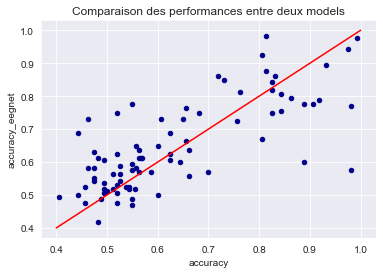

In [126]:

ax1 = data_cleaned.plot.scatter(x='accuracy',y='accuracy_eegnet', c='DarkBlue')
ax1.plot([0.4,1],[0.4,1], c="red")
ax1.set_title("Comparaison des performances entre deux models")

In [136]:
liste = []
for val in dict_age.values():
    print(data_cleaned.loc[val].mean())

accuracy            0.706731
age                22.076923
accuracy_eegnet     0.767308
dtype: float64
accuracy            0.574792
age                24.000000
accuracy_eegnet     0.625000
dtype: float64
accuracy            0.632721
age                25.705882
accuracy_eegnet     0.668015
dtype: float64
accuracy            0.639563
age                28.583333
accuracy_eegnet     0.625000
dtype: float64
accuracy            0.623828
age                34.812500
accuracy_eegnet     0.626172
dtype: float64
accuracy            0.615982
age                48.000000
accuracy_eegnet     0.581250
dtype: float64


In [134]:
data_cleaned.loc[val]

,accuracy,age,accuracy_eegnet
A25,0.81250,22,0.87500
A26,0.65625,23,0.76250
A56,0.99375,23,0.97500
B63,0.60000,21,0.65000
B65,0.82500,23,0.75000
B68,0.55000,22,0.46875
B70,0.55625,23,0.58125
B75,0.71875,23,0.86250
B76,0.80625,23,0.92500
B78,0.55000,22,0.77500


In [145]:
n_chans = 27
input_window_samples = 1024
# sfreq = dic_data_train['A1_1'].info["sfreq"]
# ch_names = dic_data_train['A1_1'].info["ch_names"]
n_epochs = 500
cuda = torch.cuda.is_available()
# device = 'cuda' if cuda else 'cpu'
n_classes = 2
batch_size = 32

In [146]:
model = EEGNet(nb_classes = n_classes, Chans = n_chans, Samples = input_window_samples)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam' , metrics= BinaryAccuracy())
my_callbacks = [
    EarlyStopping(patience= 50, monitor = "loss"),
    ModelCheckpoint(filepath='./model/model.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True),
    TensorBoard(log_dir='./logs'),
]

In [147]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 27, 1024, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 27, 1024, 8)       512       
                                                                 
 batch_normalization_9 (Batc  (None, 27, 1024, 8)      32        
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_3 (Depthwi  (None, 1, 1024, 16)      432       
 seConv2D)                                                       
                                                                 
 batch_normalization_10 (Bat  (None, 1, 1024, 16)      64        
 chNormalization)                                                
                                                           

In [148]:
fit_model =  model.fit(x= X_train_pre,
                       y= Y_train_pre,
                       batch_size = batch_size,
                       epochs = n_epochs ,
                       callbacks= my_callbacks,
                       validation_data= (X_train_post,Y_train_post))

Epoch 1/500
432/432 [==============================] - 7s 14ms/step - loss: 0.6937 - binary_accuracy: 0.4963 - val_loss: 0.6952 - val_binary_accuracy: 0.5007
Epoch 2/500
432/432 [==============================] - 6s 13ms/step - loss: 0.6937 - binary_accuracy: 0.5025 - val_loss: 0.7479 - val_binary_accuracy: 0.5007
Epoch 3/500
432/432 [==============================] - 6s 13ms/step - loss: 0.6928 - binary_accuracy: 0.5127 - val_loss: 0.6941 - val_binary_accuracy: 0.4935
Epoch 4/500
432/432 [==============================] - 6s 13ms/step - loss: 0.6923 - binary_accuracy: 0.5172 - val_loss: 0.6953 - val_binary_accuracy: 0.4993
Epoch 5/500
432/432 [==============================] - 6s 13ms/step - loss: 0.6924 - binary_accuracy: 0.5203 - val_loss: 0.9121 - val_binary_accuracy: 0.4993
Epoch 6/500
432/432 [==============================] - 6s 13ms/step - loss: 0.6915 - binary_accuracy: 0.5218 - val_loss: 0.7133 - val_binary_accuracy: 0.5000
Epoch 7/500
432/432 [==============================]

In [56]:
model.evaluate(x= X_test, y =Y_test)

NameError: name 'X_test' is not defined

In [165]:
from keras.models import load_model
best_model = load_model('.\model\model.94-0.63.h5')
best_model.evaluate(x= X_valid_train, y = Y_valid_train)

3/3 [==============================] - 0s 21ms/step - loss: 0.6781 - binary_accuracy: 0.6500


[0.6780735850334167, 0.6499999761581421]

In [166]:
best_model.evaluate(x= X_valid_test, y = Y_valid_test)

5/5 [==============================] - 0s 30ms/step - loss: 0.6697 - binary_accuracy: 0.6000


[0.6696761250495911, 0.6000000238418579]

In [168]:
best_model.evaluate(x= X_train_post, y = Y_train_post)

48/48 [==============================] - 0s 4ms/step - loss: 0.6279 - binary_accuracy: 0.6504


[0.6279155611991882, 0.650390625]

In [62]:
best_model.fit(x= valid_train_gen ,
               batch_size = batch_size,
               callbacks= my_callbacks ,
               epochs= 10 ,
               validation_data= valid_test_gen)

Epoch 1/10
28/28 [==============================] - 2s 49ms/step - loss: 0.5796 - binary_accuracy: 0.6830 - val_loss: 1.0856 - val_binary_accuracy: 0.5026
Epoch 2/10
28/28 [==============================] - 1s 33ms/step - loss: 0.5492 - binary_accuracy: 0.7091 - val_loss: 2.3417 - val_binary_accuracy: 0.5000
Epoch 3/10
28/28 [==============================] - 1s 33ms/step - loss: 0.5424 - binary_accuracy: 0.7239 - val_loss: 1.2540 - val_binary_accuracy: 0.5073
Epoch 4/10
28/28 [==============================] - 1s 33ms/step - loss: 0.5320 - binary_accuracy: 0.7261 - val_loss: 0.6867 - val_binary_accuracy: 0.5741
Epoch 5/10
28/28 [==============================] - 1s 33ms/step - loss: 0.5353 - binary_accuracy: 0.7193 - val_loss: 0.7174 - val_binary_accuracy: 0.5343
Epoch 6/10
28/28 [==============================] - 1s 33ms/step - loss: 0.5340 - binary_accuracy: 0.7403 - val_loss: 1.1373 - val_binary_accuracy: 0.5235
Epoch 7/10
28/28 [==============================] - 1s 32ms/step - los

In [300]:
init_path = "C:\\Users\dtrocell\Documents\ML\Big dataset\signal"
valid_dataset = np.array(pd.read_csv(init_path+"\\validkey.csv", index_col=0).index)

array(['A8', 'B75', 'A45', 'A56', 'A37', 'B77', 'A60', 'B62', 'A28', 'A4',
       'A22', 'B70', 'A33', 'A59', 'B73', 'A20', 'A36', 'A29', 'A58',
       'A14', 'C84', 'A16'], dtype=object)

In [301]:
files_dir=os.listdir(init_path)[:3]

participant_dir = [[],[],[]]
for val in valid_dataset :
    if val[0] == "A":
        participant_dir[0].append(val)
    elif val[0] == "B":
        participant_dir[1].append(val)
    elif val[0] == "C":
        participant_dir[2].append(val)
    else:
        print("erreur")

dic_data =  collect_data(files_dir, participant_dir)

In [302]:
directory_model = '.\model\model.118-0.61.h5'
my_callbacks = [
    EarlyStopping(patience= 10, monitor = "loss"),
    ModelCheckpoint(filepath='./model/best_model_finetuned.h5', save_best_only=True),
    TensorBoard(log_dir='./logs'),
]

In [303]:
steps_preprocess = {"filter" : [8,30],
                    "drop_channels" : ['EOG1', 'EOG2', 'EOG3', 'EMGg', 'EMGd'] ,
                    "tmin" : 0.5 , "tmax" : 2.5, "overlap" :1, "lenght": 2,
                    "score" : "TAcc"}
#
# def create_key(df , train = 1 , test_1 = 1 , test_2 = 1):
#
#     keys = np.array([])
#
#     for  val  in df :
#         if train :
#             keys = np.append(keys, [val+"_1" ,val+"_2"])
#         if test_1 :
#                 keys = np.append(keys, [val+"_3" ,val+"_4"])
#         if test_2 :
#             if val != "A59":
#                 keys = np.append(keys, [val+"_5" ,val+"_6"])
#     return keys

In [345]:

accuracy = pd.DataFrame( index=valid_dataset ,  columns= ["base", "fine_tuned"])

for key in valid_dataset :

    # extrait les données à partir de mne
    # les converties en CSV

    key_valid_train  = create_key([key] , train = 1 , test = 0 )
    key_valid_test  = create_key([key] , train = 0 , test = 1 )


    mask =np.array([True,False] *  int(key_valid_test.shape[0]/2))
    np.random.shuffle(mask)
    key_test = key_valid_test[mask]
    key_valid = key_valid_test[~mask]




    X_valid_train, Y_valid_train = epoching(dic_data,key_valid_train, steps_preprocess)
    X_valid, Y_valid = epoching(dic_data,key_valid, steps_preprocess)
    X_test, Y_test = epoching(dic_data,key_test, steps_preprocess)


    # read the model

    model = load_model(directory_model)
    accuracy.base[key]= model.evaluate(X_test, Y_test)[1]

    #Fine tune le model sur le train

    # Allow to finetuned te model only on some layers
    for layer in model.layers :
        layer.trainable = False

    model.layers[-2].trainable = True   # last layer Dense
    #reset the weight of the layers

    ix = -2
    layer = model.layers[-2]
    if hasattr(model.layers[ix], 'kernel_initializer') and hasattr(model.layers[ix], 'bias_initializer'):
        weight_initializer = model.layers[ix].kernel_initializer
        bias_initializer = model.layers[ix].bias_initializer

        old_weights, old_biases = model.layers[ix].get_weights()

        model.layers[ix].set_weights([
            weight_initializer(shape=old_weights.shape),
            bias_initializer(shape=len(old_biases))])

    # fit the model
    model.fit(x = X_valid_train, y = Y_valid_train,
              batch_size = batch_size,
              epochs = n_epochs ,
              callbacks= my_callbacks,
              validation_data= (X_valid,Y_valid))

    # Test le model

    model = load_model("./model/best_model_finetuned.h5")

    #enregistre l'accuracy
    accuracy.fine_tuned[key]= model.evaluate(X_test, Y_test)[1]



epoching: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


3/3 [==============================] - 0s 21ms/step - loss: 0.6421 - binary_accuracy: 0.6375
Epoch 1/500
3/3 [==============================] - 0s 95ms/step - loss: 0.7509 - binary_accuracy: 0.5250 - val_loss: 0.7360 - val_binary_accuracy: 0.4875
Epoch 2/500
3/3 [==============================] - 0s 32ms/step - loss: 0.6762 - binary_accuracy: 0.5500 - val_loss: 0.7307 - val_binary_accuracy: 0.4750
Epoch 3/500
3/3 [==============================] - 0s 32ms/step - loss: 0.6586 - binary_accuracy: 0.6000 - val_loss: 0.7236 - val_binary_accuracy: 0.4500
Epoch 4/500
3/3 [==============================] - 0s 32ms/step - loss: 0.6377 - binary_accuracy: 0.6750 - val_loss: 0.7151 - val_binary_accuracy: 0.4875
Epoch 5/500
3/3 [==============================] - 0s 32ms/step - loss: 0.6185 - binary_accuracy: 0.7000 - val_loss: 0.7141 - val_binary_accuracy: 0.4875
Epoch 6/500
3/3 [==============================] - 0s 31ms/step - loss: 0.5759 - binary_accuracy: 0.7625 - val_loss: 0.7278 - val_binary_

epoching: 100%|██████████| 2/2 [00:00<00:00,  4.42it/s]

1/3 [=========>....................] - ETA: 0s - loss: 0.6426 - binary_accuracy: 0.5938

3/3 [==============================] - 0s 5ms/step - loss: 0.6566 - binary_accuracy: 0.6125
Epoch 1/500
3/3 [==============================] - 0s 80ms/step - loss: 0.7323 - binary_accuracy: 0.4625 - val_loss: 0.7128 - val_binary_accuracy: 0.5000
Epoch 2/500
3/3 [==============================] - 0s 83ms/step - loss: 0.6668 - binary_accuracy: 0.5875 - val_loss: 0.7389 - val_binary_accuracy: 0.5000
Epoch 3/500
3/3 [==============================] - 0s 38ms/step - loss: 0.6617 - binary_accuracy: 0.5875 - val_loss: 0.7696 - val_binary_accuracy: 0.5000
Epoch 4/500
3/3 [==============================] - 0s 38ms/step - loss: 0.6287 - binary_accuracy: 0.7125 - val_loss: 0.8121 - val_binary_accuracy: 0.5000
Epoch 5/500
3/3 [==============================] - 0s 35ms/step - loss: 0.6124 - binary_accuracy: 0.8000 - val_loss: 0.8362 - val_binary_accuracy: 0.5000
Epoch 6/500
3/3 [==============================] - 0s 35ms/step - loss: 0.5942 - binary_accuracy: 0.7625 - val_loss: 0.8179 - val_binary_a

epoching: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


3/3 [==============================] - 0s 11ms/step - loss: 0.6969 - binary_accuracy: 0.5250
Epoch 1/500
3/3 [==============================] - 0s 80ms/step - loss: 0.6869 - binary_accuracy: 0.5375 - val_loss: 0.7144 - val_binary_accuracy: 0.3875
Epoch 2/500
3/3 [==============================] - 0s 49ms/step - loss: 0.6639 - binary_accuracy: 0.5750 - val_loss: 0.7136 - val_binary_accuracy: 0.4500
Epoch 3/500
3/3 [==============================] - 0s 38ms/step - loss: 0.6660 - binary_accuracy: 0.6000 - val_loss: 0.7120 - val_binary_accuracy: 0.4375
Epoch 4/500
3/3 [==============================] - 0s 38ms/step - loss: 0.6347 - binary_accuracy: 0.7000 - val_loss: 0.7080 - val_binary_accuracy: 0.4875
Epoch 5/500
3/3 [==============================] - 0s 36ms/step - loss: 0.5880 - binary_accuracy: 0.8250 - val_loss: 0.7146 - val_binary_accuracy: 0.4625
Epoch 6/500
3/3 [==============================] - 0s 35ms/step - loss: 0.5843 - binary_accuracy: 0.7625 - val_loss: 0.7639 - val_binary_

epoching: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


3/3 [==============================] - 0s 11ms/step - loss: 0.2678 - binary_accuracy: 0.9375
Epoch 1/500
3/3 [==============================] - 0s 84ms/step - loss: 0.8002 - binary_accuracy: 0.5500 - val_loss: 0.6644 - val_binary_accuracy: 0.6000
Epoch 2/500
3/3 [==============================] - 0s 67ms/step - loss: 0.5752 - binary_accuracy: 0.8375 - val_loss: 0.5944 - val_binary_accuracy: 0.7125
Epoch 3/500
3/3 [==============================] - 0s 54ms/step - loss: 0.4427 - binary_accuracy: 0.9250 - val_loss: 0.5584 - val_binary_accuracy: 0.6875
Epoch 4/500
3/3 [==============================] - 0s 36ms/step - loss: 0.3478 - binary_accuracy: 0.9375 - val_loss: 0.5837 - val_binary_accuracy: 0.6375
Epoch 5/500
3/3 [==============================] - 0s 36ms/step - loss: 0.2817 - binary_accuracy: 0.9625 - val_loss: 0.6516 - val_binary_accuracy: 0.5750
Epoch 6/500
3/3 [==============================] - 0s 36ms/step - loss: 0.2408 - binary_accuracy: 0.9500 - val_loss: 0.7477 - val_binary_

epoching: 100%|██████████| 2/2 [00:00<00:00,  4.15it/s]


3/3 [==============================] - 0s 11ms/step - loss: 0.6576 - binary_accuracy: 0.6375
Epoch 1/500
3/3 [==============================] - 0s 82ms/step - loss: 0.7438 - binary_accuracy: 0.5125 - val_loss: 0.6826 - val_binary_accuracy: 0.5375
Epoch 2/500
3/3 [==============================] - 0s 63ms/step - loss: 0.6852 - binary_accuracy: 0.5500 - val_loss: 0.6912 - val_binary_accuracy: 0.5000
Epoch 3/500
3/3 [==============================] - 0s 52ms/step - loss: 0.6407 - binary_accuracy: 0.6625 - val_loss: 0.7239 - val_binary_accuracy: 0.5000
Epoch 4/500
3/3 [==============================] - 0s 34ms/step - loss: 0.6033 - binary_accuracy: 0.8250 - val_loss: 0.8065 - val_binary_accuracy: 0.5000
Epoch 5/500
3/3 [==============================] - 0s 36ms/step - loss: 0.5832 - binary_accuracy: 0.8000 - val_loss: 0.8995 - val_binary_accuracy: 0.5000
Epoch 6/500
3/3 [==============================] - 0s 35ms/step - loss: 0.5417 - binary_accuracy: 0.8375 - val_loss: 0.9792 - val_binary_

epoching: 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

1/3 [=========>....................] - ETA: 0s - loss: 0.7015 - binary_accuracy: 0.5000

3/3 [==============================] - 0s 5ms/step - loss: 0.6841 - binary_accuracy: 0.5250
Epoch 1/500
3/3 [==============================] - 0s 71ms/step - loss: 0.7357 - binary_accuracy: 0.4375 - val_loss: 0.7071 - val_binary_accuracy: 0.5000
Epoch 2/500
3/3 [==============================] - 0s 42ms/step - loss: 0.6952 - binary_accuracy: 0.5000 - val_loss: 0.7122 - val_binary_accuracy: 0.5000
Epoch 3/500
3/3 [==============================] - 0s 41ms/step - loss: 0.6791 - binary_accuracy: 0.5750 - val_loss: 0.7079 - val_binary_accuracy: 0.5000
Epoch 4/500
3/3 [==============================] - 0s 40ms/step - loss: 0.6686 - binary_accuracy: 0.6375 - val_loss: 0.6987 - val_binary_accuracy: 0.5000
Epoch 5/500
3/3 [==============================] - 0s 36ms/step - loss: 0.6571 - binary_accuracy: 0.7250 - val_loss: 0.6947 - val_binary_accuracy: 0.5125
Epoch 6/500
3/3 [==============================] - 0s 36ms/step - loss: 0.6381 - binary_accuracy: 0.7375 - val_loss: 0.6936 - val_binary_a

epoching: 100%|██████████| 2/2 [00:00<00:00,  4.35it/s]

1/3 [=========>....................] - ETA: 0s - loss: 0.6429 - binary_accuracy: 0.6562

3/3 [==============================] - 0s 11ms/step - loss: 0.6227 - binary_accuracy: 0.6875
Epoch 1/500
3/3 [==============================] - 0s 85ms/step - loss: 0.7184 - binary_accuracy: 0.5500 - val_loss: 0.7189 - val_binary_accuracy: 0.5000
Epoch 2/500
3/3 [==============================] - 0s 65ms/step - loss: 0.6641 - binary_accuracy: 0.6250 - val_loss: 0.7119 - val_binary_accuracy: 0.4750
Epoch 3/500
3/3 [==============================] - 0s 39ms/step - loss: 0.6418 - binary_accuracy: 0.6625 - val_loss: 0.7045 - val_binary_accuracy: 0.4750
Epoch 4/500
3/3 [==============================] - 0s 38ms/step - loss: 0.5809 - binary_accuracy: 0.8375 - val_loss: 0.7013 - val_binary_accuracy: 0.5375
Epoch 5/500
3/3 [==============================] - 0s 35ms/step - loss: 0.5554 - binary_accuracy: 0.8250 - val_loss: 0.6990 - val_binary_accuracy: 0.5625
Epoch 6/500
3/3 [==============================] - 0s 35ms/step - loss: 0.5310 - binary_accuracy: 0.8250 - val_loss: 0.7075 - val_binary_

epoching: 100%|██████████| 2/2 [00:00<00:00,  4.72it/s]


3/3 [==============================] - 0s 5ms/step - loss: 0.4013 - binary_accuracy: 0.9000
Epoch 1/500
3/3 [==============================] - 0s 59ms/step - loss: 0.9247 - binary_accuracy: 0.4250 - val_loss: 0.6686 - val_binary_accuracy: 0.6000
Epoch 2/500
3/3 [==============================] - 0s 41ms/step - loss: 0.6523 - binary_accuracy: 0.6625 - val_loss: 0.6136 - val_binary_accuracy: 0.7250
Epoch 3/500
3/3 [==============================] - 0s 40ms/step - loss: 0.5222 - binary_accuracy: 0.8125 - val_loss: 0.6436 - val_binary_accuracy: 0.5750
Epoch 4/500
3/3 [==============================] - 0s 37ms/step - loss: 0.4546 - binary_accuracy: 0.8750 - val_loss: 0.7975 - val_binary_accuracy: 0.5125
Epoch 5/500
3/3 [==============================] - 0s 36ms/step - loss: 0.3990 - binary_accuracy: 0.8750 - val_loss: 1.0537 - val_binary_accuracy: 0.5000
Epoch 6/500
3/3 [==============================] - 0s 34ms/step - loss: 0.3544 - binary_accuracy: 0.9125 - val_loss: 1.3695 - val_binary_a

epoching: 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]

1/3 [=========>....................] - ETA: 0s - loss: 0.6371 - binary_accuracy: 0.5938

3/3 [==============================] - 0s 5ms/step - loss: 0.6829 - binary_accuracy: 0.5750
Epoch 1/500
3/3 [==============================] - 0s 79ms/step - loss: 0.7715 - binary_accuracy: 0.4875 - val_loss: 0.7129 - val_binary_accuracy: 0.4750
Epoch 2/500
3/3 [==============================] - 0s 43ms/step - loss: 0.6792 - binary_accuracy: 0.5750 - val_loss: 0.7023 - val_binary_accuracy: 0.5250
Epoch 3/500
3/3 [==============================] - 0s 39ms/step - loss: 0.6547 - binary_accuracy: 0.7250 - val_loss: 0.6882 - val_binary_accuracy: 0.4500
Epoch 4/500
3/3 [==============================] - 0s 36ms/step - loss: 0.6121 - binary_accuracy: 0.7375 - val_loss: 0.6854 - val_binary_accuracy: 0.4875
Epoch 5/500
3/3 [==============================] - 0s 37ms/step - loss: 0.5891 - binary_accuracy: 0.7250 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 6/500
3/3 [==============================] - 0s 37ms/step - loss: 0.5639 - binary_accuracy: 0.7375 - val_loss: 0.6930 - val_binary_a

epoching: 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]


3/3 [==============================] - 0s 11ms/step - loss: 0.6625 - binary_accuracy: 0.5750
Epoch 1/500
3/3 [==============================] - 0s 81ms/step - loss: 0.7343 - binary_accuracy: 0.4500 - val_loss: 0.6995 - val_binary_accuracy: 0.4875
Epoch 2/500
3/3 [==============================] - 0s 55ms/step - loss: 0.7059 - binary_accuracy: 0.5000 - val_loss: 0.7775 - val_binary_accuracy: 0.4875
Epoch 3/500
3/3 [==============================] - 0s 39ms/step - loss: 0.6784 - binary_accuracy: 0.5500 - val_loss: 0.8297 - val_binary_accuracy: 0.4875
Epoch 4/500
3/3 [==============================] - 0s 38ms/step - loss: 0.6685 - binary_accuracy: 0.5375 - val_loss: 0.8940 - val_binary_accuracy: 0.4750
Epoch 5/500
3/3 [==============================] - 0s 35ms/step - loss: 0.6641 - binary_accuracy: 0.5625 - val_loss: 0.9922 - val_binary_accuracy: 0.4375
Epoch 6/500
3/3 [==============================] - 0s 59ms/step - loss: 0.6566 - binary_accuracy: 0.6375 - val_loss: 1.1100 - val_binary_

epoching: 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]


3/3 [==============================] - 0s 10ms/step - loss: 0.6509 - binary_accuracy: 0.6250
Epoch 1/500
3/3 [==============================] - 0s 81ms/step - loss: 0.7866 - binary_accuracy: 0.5250 - val_loss: 0.8874 - val_binary_accuracy: 0.5000
Epoch 2/500
3/3 [==============================] - 0s 66ms/step - loss: 0.6852 - binary_accuracy: 0.5500 - val_loss: 1.0121 - val_binary_accuracy: 0.5000
Epoch 3/500
3/3 [==============================] - 0s 41ms/step - loss: 0.6494 - binary_accuracy: 0.6375 - val_loss: 1.1101 - val_binary_accuracy: 0.5000
Epoch 4/500
3/3 [==============================] - 0s 39ms/step - loss: 0.6336 - binary_accuracy: 0.7125 - val_loss: 1.1539 - val_binary_accuracy: 0.5000
Epoch 5/500
3/3 [==============================] - 0s 34ms/step - loss: 0.5811 - binary_accuracy: 0.8125 - val_loss: 1.1584 - val_binary_accuracy: 0.5000
Epoch 6/500
3/3 [==============================] - 0s 34ms/step - loss: 0.5835 - binary_accuracy: 0.7750 - val_loss: 1.1149 - val_binary_

epoching: 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]

1/3 [=========>....................] - ETA: 0s - loss: 0.6472 - binary_accuracy: 0.6875

3/3 [==============================] - 0s 4ms/step - loss: 0.6624 - binary_accuracy: 0.6375
Epoch 1/500
3/3 [==============================] - 0s 59ms/step - loss: 0.7313 - binary_accuracy: 0.5125 - val_loss: 0.7175 - val_binary_accuracy: 0.5000
Epoch 2/500
3/3 [==============================] - 0s 41ms/step - loss: 0.6924 - binary_accuracy: 0.5125 - val_loss: 0.7115 - val_binary_accuracy: 0.5375
Epoch 3/500
3/3 [==============================] - 0s 42ms/step - loss: 0.6731 - binary_accuracy: 0.6000 - val_loss: 0.7160 - val_binary_accuracy: 0.5250
Epoch 4/500
3/3 [==============================] - 0s 38ms/step - loss: 0.6528 - binary_accuracy: 0.6500 - val_loss: 0.7251 - val_binary_accuracy: 0.5375
Epoch 5/500
3/3 [==============================] - 0s 36ms/step - loss: 0.6259 - binary_accuracy: 0.7000 - val_loss: 0.7387 - val_binary_accuracy: 0.4625
Epoch 6/500
3/3 [==============================] - 0s 35ms/step - loss: 0.6057 - binary_accuracy: 0.7250 - val_loss: 0.7813 - val_binary_a

epoching: 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

1/3 [=========>....................] - ETA: 0s - loss: 0.6605 - binary_accuracy: 0.5938

3/3 [==============================] - 0s 10ms/step - loss: 0.6564 - binary_accuracy: 0.6375
Epoch 1/500
3/3 [==============================] - 0s 81ms/step - loss: 0.7226 - binary_accuracy: 0.6000 - val_loss: 0.6898 - val_binary_accuracy: 0.5000
Epoch 2/500
3/3 [==============================] - 0s 65ms/step - loss: 0.6769 - binary_accuracy: 0.6125 - val_loss: 0.6845 - val_binary_accuracy: 0.5375
Epoch 3/500
3/3 [==============================] - 0s 41ms/step - loss: 0.6142 - binary_accuracy: 0.7125 - val_loss: 0.7364 - val_binary_accuracy: 0.5000
Epoch 4/500
3/3 [==============================] - 0s 40ms/step - loss: 0.5749 - binary_accuracy: 0.8125 - val_loss: 1.2738 - val_binary_accuracy: 0.5000
Epoch 5/500
3/3 [==============================] - 0s 38ms/step - loss: 0.5096 - binary_accuracy: 0.8500 - val_loss: 2.6742 - val_binary_accuracy: 0.5000
Epoch 6/500
3/3 [==============================] - 0s 36ms/step - loss: 0.4720 - binary_accuracy: 0.8875 - val_loss: 4.6181 - val_binary_

epoching: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

1/2 [==============>...............] - ETA: 0s - loss: 0.6130 - binary_accuracy: 0.5625

2/2 [==============================] - 0s 3ms/step - loss: 0.6252 - binary_accuracy: 0.5500
Epoch 1/500
3/3 [==============================] - 0s 70ms/step - loss: 0.7433 - binary_accuracy: 0.5625 - val_loss: 0.7106 - val_binary_accuracy: 0.5250
Epoch 2/500
3/3 [==============================] - 0s 39ms/step - loss: 0.6582 - binary_accuracy: 0.6750 - val_loss: 0.6812 - val_binary_accuracy: 0.5250
Epoch 3/500
3/3 [==============================] - 0s 38ms/step - loss: 0.6161 - binary_accuracy: 0.6750 - val_loss: 0.6552 - val_binary_accuracy: 0.5500
Epoch 4/500
3/3 [==============================] - 0s 34ms/step - loss: 0.5634 - binary_accuracy: 0.7875 - val_loss: 0.6450 - val_binary_accuracy: 0.5750
Epoch 5/500
3/3 [==============================] - 0s 35ms/step - loss: 0.5213 - binary_accuracy: 0.8250 - val_loss: 0.6382 - val_binary_accuracy: 0.5750
Epoch 6/500
3/3 [==============================] - 0s 33ms/step - loss: 0.5092 - binary_accuracy: 0.8625 - val_loss: 0.6298 - val_binary_a

epoching: 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]


3/3 [==============================] - 0s 11ms/step - loss: 0.5636 - binary_accuracy: 0.6500
Epoch 1/500
3/3 [==============================] - 0s 85ms/step - loss: 0.7426 - binary_accuracy: 0.5125 - val_loss: 0.6989 - val_binary_accuracy: 0.5125
Epoch 2/500
3/3 [==============================] - 0s 63ms/step - loss: 0.6633 - binary_accuracy: 0.6375 - val_loss: 0.6736 - val_binary_accuracy: 0.5250
Epoch 3/500
3/3 [==============================] - 0s 35ms/step - loss: 0.6198 - binary_accuracy: 0.7500 - val_loss: 0.6471 - val_binary_accuracy: 0.7625
Epoch 4/500
3/3 [==============================] - 0s 36ms/step - loss: 0.5687 - binary_accuracy: 0.8875 - val_loss: 0.6447 - val_binary_accuracy: 0.5750
Epoch 5/500
3/3 [==============================] - 0s 34ms/step - loss: 0.5209 - binary_accuracy: 0.8750 - val_loss: 0.6636 - val_binary_accuracy: 0.5125
Epoch 6/500
3/3 [==============================] - 0s 35ms/step - loss: 0.4670 - binary_accuracy: 0.9125 - val_loss: 0.6511 - val_binary_

epoching: 100%|██████████| 2/2 [00:00<00:00,  4.82it/s]

1/3 [=========>....................] - ETA: 0s - loss: 0.3334 - binary_accuracy: 0.8438

3/3 [==============================] - 0s 5ms/step - loss: 0.3370 - binary_accuracy: 0.8500
Epoch 1/500
3/3 [==============================] - 0s 81ms/step - loss: 0.8149 - binary_accuracy: 0.5000 - val_loss: 0.7642 - val_binary_accuracy: 0.5000
Epoch 2/500
3/3 [==============================] - 0s 39ms/step - loss: 0.6532 - binary_accuracy: 0.6125 - val_loss: 0.7485 - val_binary_accuracy: 0.5000
Epoch 3/500
3/3 [==============================] - 0s 41ms/step - loss: 0.5954 - binary_accuracy: 0.6875 - val_loss: 0.7204 - val_binary_accuracy: 0.5000
Epoch 4/500
3/3 [==============================] - 0s 37ms/step - loss: 0.5286 - binary_accuracy: 0.8375 - val_loss: 0.7211 - val_binary_accuracy: 0.5250
Epoch 5/500
3/3 [==============================] - 0s 38ms/step - loss: 0.4908 - binary_accuracy: 0.8250 - val_loss: 0.9154 - val_binary_accuracy: 0.5125
Epoch 6/500
3/3 [==============================] - 0s 37ms/step - loss: 0.4603 - binary_accuracy: 0.8000 - val_loss: 1.3361 - val_binary_a

epoching: 100%|██████████| 2/2 [00:00<00:00,  4.92it/s]

1/3 [=========>....................] - ETA: 0s - loss: 0.7281 - binary_accuracy: 0.4688

3/3 [==============================] - 0s 4ms/step - loss: 0.6730 - binary_accuracy: 0.6375
Epoch 1/500
3/3 [==============================] - 0s 80ms/step - loss: 0.7111 - binary_accuracy: 0.5500 - val_loss: 0.7806 - val_binary_accuracy: 0.5000
Epoch 2/500
3/3 [==============================] - 0s 63ms/step - loss: 0.6614 - binary_accuracy: 0.5875 - val_loss: 0.7829 - val_binary_accuracy: 0.5000
Epoch 3/500
3/3 [==============================] - 0s 37ms/step - loss: 0.6544 - binary_accuracy: 0.6375 - val_loss: 0.7787 - val_binary_accuracy: 0.5000
Epoch 4/500
3/3 [==============================] - 0s 36ms/step - loss: 0.6279 - binary_accuracy: 0.7000 - val_loss: 0.7580 - val_binary_accuracy: 0.5000
Epoch 5/500
3/3 [==============================] - 0s 34ms/step - loss: 0.6197 - binary_accuracy: 0.7625 - val_loss: 0.7313 - val_binary_accuracy: 0.5000
Epoch 6/500
3/3 [==============================] - 0s 34ms/step - loss: 0.5728 - binary_accuracy: 0.8500 - val_loss: 0.6916 - val_binary_a

epoching: 100%|██████████| 2/2 [00:00<00:00,  4.92it/s]

1/3 [=========>....................] - ETA: 0s - loss: 0.7009 - binary_accuracy: 0.6250

3/3 [==============================] - 0s 5ms/step - loss: 0.7667 - binary_accuracy: 0.6125
Epoch 1/500
3/3 [==============================] - 0s 70ms/step - loss: 0.7321 - binary_accuracy: 0.5500 - val_loss: 0.7166 - val_binary_accuracy: 0.5125
Epoch 2/500
3/3 [==============================] - 0s 41ms/step - loss: 0.6660 - binary_accuracy: 0.6125 - val_loss: 0.6910 - val_binary_accuracy: 0.5250
Epoch 3/500
3/3 [==============================] - 0s 39ms/step - loss: 0.6211 - binary_accuracy: 0.6750 - val_loss: 0.6679 - val_binary_accuracy: 0.5625
Epoch 4/500
3/3 [==============================] - 0s 37ms/step - loss: 0.5854 - binary_accuracy: 0.7000 - val_loss: 0.6724 - val_binary_accuracy: 0.5500
Epoch 5/500
3/3 [==============================] - 0s 42ms/step - loss: 0.5532 - binary_accuracy: 0.7625 - val_loss: 0.7252 - val_binary_accuracy: 0.5500
Epoch 6/500
3/3 [==============================] - 0s 41ms/step - loss: 0.5400 - binary_accuracy: 0.6875 - val_loss: 0.8525 - val_binary_a

epoching: 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]


3/3 [==============================] - 0s 10ms/step - loss: 0.6197 - binary_accuracy: 0.7125
Epoch 1/500
3/3 [==============================] - 0s 94ms/step - loss: 0.7045 - binary_accuracy: 0.5375 - val_loss: 0.6822 - val_binary_accuracy: 0.5250
Epoch 2/500
3/3 [==============================] - 0s 61ms/step - loss: 0.6500 - binary_accuracy: 0.6125 - val_loss: 0.6698 - val_binary_accuracy: 0.5500
Epoch 3/500
3/3 [==============================] - 0s 48ms/step - loss: 0.6272 - binary_accuracy: 0.7375 - val_loss: 0.6548 - val_binary_accuracy: 0.6500
Epoch 4/500
3/3 [==============================] - 0s 49ms/step - loss: 0.5924 - binary_accuracy: 0.7625 - val_loss: 0.6648 - val_binary_accuracy: 0.5625
Epoch 5/500
3/3 [==============================] - 0s 47ms/step - loss: 0.5514 - binary_accuracy: 0.8750 - val_loss: 0.7999 - val_binary_accuracy: 0.5000
Epoch 6/500
3/3 [==============================] - 0s 43ms/step - loss: 0.4996 - binary_accuracy: 0.8875 - val_loss: 1.3842 - val_binary_

epoching: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


3/3 [==============================] - 0s 5ms/step - loss: 0.6945 - binary_accuracy: 0.5000
Epoch 1/500
3/3 [==============================] - 0s 80ms/step - loss: 0.7791 - binary_accuracy: 0.5250 - val_loss: 0.6919 - val_binary_accuracy: 0.4875
Epoch 2/500
3/3 [==============================] - 0s 44ms/step - loss: 0.6874 - binary_accuracy: 0.5750 - val_loss: 0.6923 - val_binary_accuracy: 0.5000
Epoch 3/500
3/3 [==============================] - 0s 38ms/step - loss: 0.6682 - binary_accuracy: 0.6500 - val_loss: 0.6868 - val_binary_accuracy: 0.5250
Epoch 4/500
3/3 [==============================] - 0s 36ms/step - loss: 0.6407 - binary_accuracy: 0.7000 - val_loss: 0.6828 - val_binary_accuracy: 0.6125
Epoch 5/500
3/3 [==============================] - 0s 36ms/step - loss: 0.6419 - binary_accuracy: 0.6625 - val_loss: 0.6951 - val_binary_accuracy: 0.5000
Epoch 6/500
3/3 [==============================] - 0s 35ms/step - loss: 0.6035 - binary_accuracy: 0.7625 - val_loss: 0.7785 - val_binary_a

epoching: 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]


3/3 [==============================] - 0s 12ms/step - loss: 0.4938 - binary_accuracy: 0.8500
Epoch 1/500
3/3 [==============================] - 0s 90ms/step - loss: 0.7229 - binary_accuracy: 0.5125 - val_loss: 0.6826 - val_binary_accuracy: 0.5875
Epoch 2/500
3/3 [==============================] - 0s 65ms/step - loss: 0.6666 - binary_accuracy: 0.6375 - val_loss: 0.7423 - val_binary_accuracy: 0.5000
Epoch 3/500
3/3 [==============================] - 0s 41ms/step - loss: 0.6125 - binary_accuracy: 0.7125 - val_loss: 1.1480 - val_binary_accuracy: 0.5000
Epoch 4/500
3/3 [==============================] - 0s 40ms/step - loss: 0.5508 - binary_accuracy: 0.8250 - val_loss: 1.9887 - val_binary_accuracy: 0.5000
Epoch 5/500
3/3 [==============================] - 0s 37ms/step - loss: 0.5256 - binary_accuracy: 0.8250 - val_loss: 2.9890 - val_binary_accuracy: 0.5000
Epoch 6/500
3/3 [==============================] - 0s 35ms/step - loss: 0.4639 - binary_accuracy: 0.8375 - val_loss: 3.6575 - val_binary_

epoching: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]

1/3 [=========>....................] - ETA: 0s - loss: 0.7043 - binary_accuracy: 0.4688

3/3 [==============================] - 0s 10ms/step - loss: 0.6828 - binary_accuracy: 0.5625
Epoch 1/500
3/3 [==============================] - 0s 80ms/step - loss: 0.7481 - binary_accuracy: 0.5125 - val_loss: 0.7251 - val_binary_accuracy: 0.5000
Epoch 2/500
3/3 [==============================] - 0s 51ms/step - loss: 0.6910 - binary_accuracy: 0.5375 - val_loss: 0.7521 - val_binary_accuracy: 0.5000
Epoch 3/500
3/3 [==============================] - 0s 40ms/step - loss: 0.6783 - binary_accuracy: 0.6000 - val_loss: 0.7421 - val_binary_accuracy: 0.5000
Epoch 4/500
3/3 [==============================] - 0s 38ms/step - loss: 0.6692 - binary_accuracy: 0.6250 - val_loss: 0.7201 - val_binary_accuracy: 0.5000
Epoch 5/500
3/3 [==============================] - 0s 36ms/step - loss: 0.6484 - binary_accuracy: 0.6625 - val_loss: 0.7008 - val_binary_accuracy: 0.5000
Epoch 6/500
3/3 [==============================] - 0s 36ms/step - loss: 0.6271 - binary_accuracy: 0.7000 - val_loss: 0.7001 - val_binary_

In [ ]:
accuracy.mean()

In [308]:
for layer in model.layers[0:5] :
    layer.trainable = False

model.layers[-2].trainable = True   # last layer Dense

In [309]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 27, 1024, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 27, 1024, 8)       512       
                                                                 
 batch_normalization_9 (Batc  (None, 27, 1024, 8)      32        
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_3 (Depthwi  (None, 1, 1024, 16)      432       
 seConv2D)                                                       
                                                                 
 batch_normalization_10 (Bat  (None, 1, 1024, 16)      64        
 chNormalization)                                                
                                                           

In [70]:
data2 = data.copy()

In [90]:
data2.to_csv("./results/temporary_acc.csv")

In [75]:
dict_age

{(19, 23): ['A25',
  'A26',
  'A56',
  'B63',
  'B65',
  'B68',
  'B70',
  'B75',
  'B76',
  'B78',
  'C84',
  'C86',
  'C87'],
 (23, 24): ['A7',
  'A10',
  'A11',
  'A13',
  'A17',
  'A29',
  'A48',
  'A50',
  'A52',
  'B71',
  'B81',
  'C83'],
 (24, 27): ['A9',
  'A14',
  'A16',
  'A18',
  'A20',
  'A23',
  'A28',
  'A30',
  'A39',
  'A42',
  'A55',
  'A57',
  'A58',
  'B74',
  'B79',
  'B80',
  'C82'],
 (27, 30): ['A1',
  'A2',
  'A8',
  'A12',
  'A33',
  'A34',
  'A35',
  'A46',
  'A53',
  'A59',
  'B61',
  'B72',
  'C85'],
 (30, 40): ['A4',
  'A5',
  'A15',
  'A19',
  'A21',
  'A22',
  'A24',
  'A27',
  'A36',
  'A41',
  'A44',
  'A47',
  'A49',
  'A54',
  'B64',
  'B69'],
 (40, 62): ['A3',
  'A6',
  'A31',
  'A32',
  'A37',
  'A38',
  'A43',
  'A45',
  'A51',
  'A60',
  'B66',
  'B67',
  'B73',
  'B77']}

In [69]:
winsound.Beep(440, 500)
winsound.Beep(330, 400)
winsound.Beep(550, 500)

Text(0.5, 1.0, 'Comparaison des performances entre deux models')

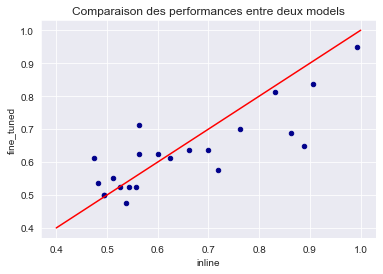

In [313]:
inline_accuracy = [84.375,55.625,98.125,51.25,51.25,65.625,47.5,56.225,66.25,82.5,51.875,60,65,49.375,75.625,49.375,45.625,82.5,98.125,83.125,56.875,88.75,51.875,93.125,81.25,65.625,45.625,48.125,52.5, 40.625, 52.5, 55.5, 62.5, 48.125, 90.625, 70, 47.5, 62.5, 81.25, 49.0625, 51.875, 51.875, 55, 56.25, 54.375, 54.375, 46.25, 56.625, 55, 52.5, 64.375, 88.75, 46.25, 47.5, 91.875, 99.375, 48.75, 66.25, 60, 56.25, 84.375, 90.625, 60, 50, 82.5, 58.75, 51.875, 55, 60.625, 55.625, 47.5, 44.375, 86.25, 68.125, 71.875, 80.625, 53.75, 55, 97.5, 49.375, 55, 49.375, 44.375, 76.25, 80.625, 62.5 ,73.125]

inline_order = ["A1"  ,"A2" ,"A3" ,"A4" ,"A5" ,"A6" ,"A7" ,"A8" ,"A9" ,"A10" ,"A11" ,"A12" ,"A13" ,"A14" ,"A15" ,"A16" ,"A17" ,"A18" ,"A19" ,"A20" ,"A21" ,"A22" ,"A23" ,"A24" ,"A25" ,"A26" ,"A27" ,"A28" ,"A29" ,"A30" ,"A31" ,"A32" ,"A33" ,"A34" ,"A35" ,"A36" ,"A37" ,"A38" ,"A39" ,"A40" ,"A41" ,"A42" ,"A43" ,"A44" ,"A45" ,"A46" ,"A47" ,"A48" ,"A49" ,"A50" ,"A51" ,"A52" ,"A53" ,"A54" ,"A55" ,"A56" ,"A57" ,"A58" ,"A59" ,"A60" ,"B61" ,"B62" ,"B63" ,"B64" ,"B65" ,"B66" ,"B67" ,"B68" ,"B69" ,"B70" ,"B71" ,"B72" ,"B73" ,"B74" ,"B75" ,"B76" ,"B77" ,"B78" ,"B79" ,"B80" ,"B81" ,"C82" ,"C83" ,"C84" ,"C85" ,"C86" ,"C87"]




inline_results = pd.DataFrame(inline_accuracy, inline_order, columns= ["inline"])
inline_results = inline_results/100

accuracy["inline"] = inline_results["inline"][accuracy.index]

ax1 = accuracy.plot.scatter(x='inline',y='fine_tuned', c='DarkBlue')
ax1.plot([0.4,1],[0.4,1], c="red")
ax1.set_title("Comparaison des performances entre deux models")

In [231]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 27, 1024, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 27, 1024, 8)       512       
                                                                 
 batch_normalization_9 (Batc  (None, 27, 1024, 8)      32        
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_3 (Depthwi  (None, 1, 1024, 16)      432       
 seConv2D)                                                       
                                                                 
 batch_normalization_10 (Bat  (None, 1, 1024, 16)      64        
 chNormalization)                                                
                                                           

In [234]:

flatten      = Flatten(name = 'flatten')(block2)

dense        = Dense(nb_classes, name = 'dense',
                     kernel_constraint = max_norm(norm_rate))(flatten)
softmax      = Activation('softmax', name = 'softmax')(dense)

AttributeError: 'list' object has no attribute 'trainable'

In [341]:
model = load_model(directory_model)
print(model.layers[-2].get_weights()[0][0])




print(model.layers[-2].get_weights()[0][0])


[ 0.01889907 -0.0188991 ]
[0.05963019 0.09490354]


In [327]:
model.evaluate(x = X_valid_train, y = Y_valid_train)

3/3 [==============================] - 0s 22ms/step - loss: 0.6624 - binary_accuracy: 0.5750


[0.6624225378036499, 0.574999988079071]

In [337]:
model.layers[-2].get_weights()[0]


array([[ 0.01889907, -0.0188991 ],
       [-0.00867759,  0.00867755],
       [-0.01202742,  0.01202741],
       ...,
       [ 0.00725783, -0.00725794],
       [ 0.01566049, -0.01566039],
       [ 0.00198506, -0.00198509]], dtype=float32)

In [ ]:

if hasattr(layer, 'kernel_initializer'):
    layer.kernel.initializer.run(session=session)
if hasattr(layer, 'bias_initializer'):
    layer.bias.initializer.run(session=session)

In [116]:
winsound.Beep(440, 5000)
winsound.Beep(330, 4000)
winsound.Beep(550, 5000)

In [353]:
inline_accuracy = [84.375, 55.625, 98.125, 51.25, 51.25, 65.625, 47.5, 56.225, 66.25, 82.5, 51.875, 60, 65, 49.375,
                   75.625, 49.375, 45.625, 82.5, 98.125, 83.125, 56.875, 88.75, 51.875, 93.125, 81.25, 65.625, 45.625,
                   48.125, 52.5, 40.625, 52.5, 55.5, 62.5, 48.125, 90.625, 70, 47.5, 62.5, 81.25, 49.0625, 51.875,
                   51.875, 55, 56.25, 54.375, 54.375, 46.25, 56.625, 55, 52.5, 64.375, 88.75, 46.25, 47.5, 91.875,
                   99.375, 48.75, 66.25, 60, 56.25, 84.375, 90.625, 60, 50, 82.5, 58.75, 51.875, 55, 60.625, 55.625,
                   47.5, 44.375, 86.25, 68.125, 71.875, 80.625, 53.75, 55, 97.5, 49.375, 55, 49.375, 44.375, 76.25,
                   80.625, 62.5, 73.125]

inline_order = ["A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "A10", "A11", "A12", "A13", "A14", "A15", "A16",
                "A17", "A18", "A19", "A20", "A21", "A22", "A23", "A24", "A25", "A26", "A27", "A28", "A29", "A30", "A31",
                "A32", "A33", "A34", "A35", "A36", "A37", "A38", "A39", "A40", "A41", "A42", "A43", "A44", "A45", "A46",
                "A47", "A48", "A49", "A50", "A51", "A52", "A53", "A54", "A55", "A56", "A57", "A58", "A59", "A60", "B61",
                "B62", "B63", "B64", "B65", "B66", "B67", "B68", "B69", "B70", "B71", "B72", "B73", "B74", "B75", "B76",
                "B77", "B78", "B79", "B80", "B81", "C82", "C83", "C84", "C85", "C86", "C87"]

inline_age = [1993, 1993, 1969, 1982, 1985, 1970, 1997, 1992, 1996, 1997, 1997, 1993, 1997, 1994, 1988, 1996, 1997,
              1995, 1985, 1996, 1988, 1989, 1994, 1985, 1999, 1998, 1981, 1995, 1997, 1996, 1978, 1969, 1992, 1993,
              1993, 1990, 1959, 1973, 1996, 1999, 1989, 1994, 1980, 1988, 1977, 1993, 1990, 1997, 1981, 1997, 1975,
              1997, 1991, 1989, 1996, 1998, 1996, 1996, 1991, 1968, 1992, 2002, 2000, 1985, 1998, 1979, 1978, 1999,
              1984, 1998, 1997, 1993, 1969, 1996, 1998, 1998, 1978, 1999, 1994, 1995, 1997, 1995, 1997, 2001, 1991,
              2000, 2000]
data = pd.DataFrame({"accuracy": inline_accuracy, "age": inline_age}, index=[inline_order])
data["age"] = 2021 - data["age"]

In [403]:


age_cat = [(19, 23), (23, 25), (25,30), (30,40), (40, 61)]

dict_age =  {}
for age_min, age_max in age_cat :

    dict_age[(age_min,age_max)] = list(data[np.logical_and(data["age"] > age_min , data["age"] <= age_max)].index)


In [404]:
for val in dict_age.values():
    print(len(val))

14
21
21
16
13


# Shalllow FBCSP net